In [ ]:
# Dataset:
    # Simulated engine degradation under different combinations of operational conditions and modes 
    # Records several sensor channels to characterize fault evolution. Provided by NASA
    # https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
# Approach:
    # Prognostics: predicting the time at which something will no longer perform it's indended function
    # Remaining Useful Life (RUL): continious target, number of useful cycles left on the engine
    # Last 15 Cycles: binary target, represents whether the asset is in the last 15 cycles of life
    # This approach predicts 'RUL' and 'Last 15 Cycles' by treating each time point independently
    # A next step is to spend time feature engineering
    # A next step would be to use LSTM or another time series appropriate deep learning approach

In [269]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = 'C:\\Users\\17146\\Desktop\\practice


In [197]:
print(os.listdir(path))

['Damage Propagation Modeling.pdf', 'readme.txt', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt', 'titanic.csv', 'train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']


In [198]:
%matplotlib inline
sns.set()

In [200]:
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [202]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [236]:
# load data
train= pd.read_csv('C:/Users/17146/Desktop/practice/train_FD001.txt', sep=" ", header=None)
test = pd.read_csv('C:/Users/17146/Desktop/practice/test_FD001.txt', sep=" ", header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)
# drop pesky NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
# name columns
train.columns = [column_names]
test.columns = [column_names]
train[train['UnitNumber'] == 1].head(5)
test[test['UnitNumber'] == 1].head(5)

train shape:  (20631, 28) test shape:  (13096, 28)


In [270]:
# this section calculates Remaining Useful Life (RUL) in T-minus notation for the training data
# find the last cycle per unit number

train.columns = train.columns.get_level_values(0)
train.groupby(['UnitNumber']).mean()
# this section calculates Remaining Useful Life (RUL) in T-minus notation for the training data
# find the last cycle per unit number
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()

max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


C:\Users\17146\Anaconda\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


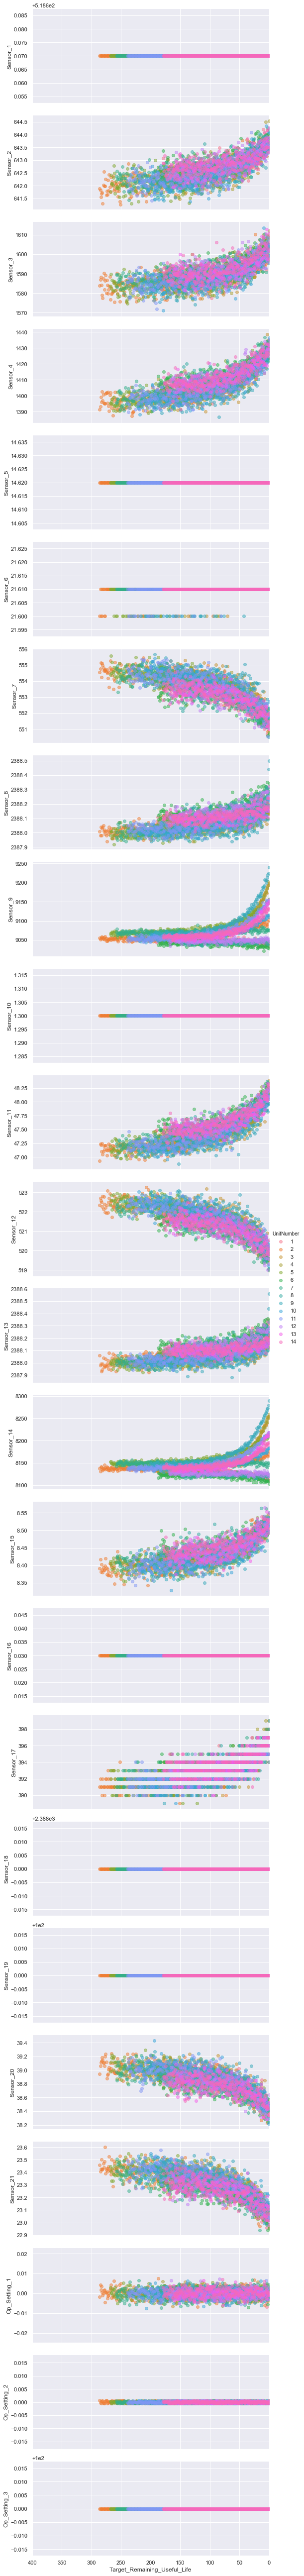

In [253]:
# use seaborn to visualize featuresto target (RUL)

explore = sns.PairGrid(data=train_with_target.query('UnitNumber < 15') ,
                 x_vars=target_var,
                 y_vars=sensor_columns + op_settings_columns,
                 hue="UnitNumber", size=3, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()

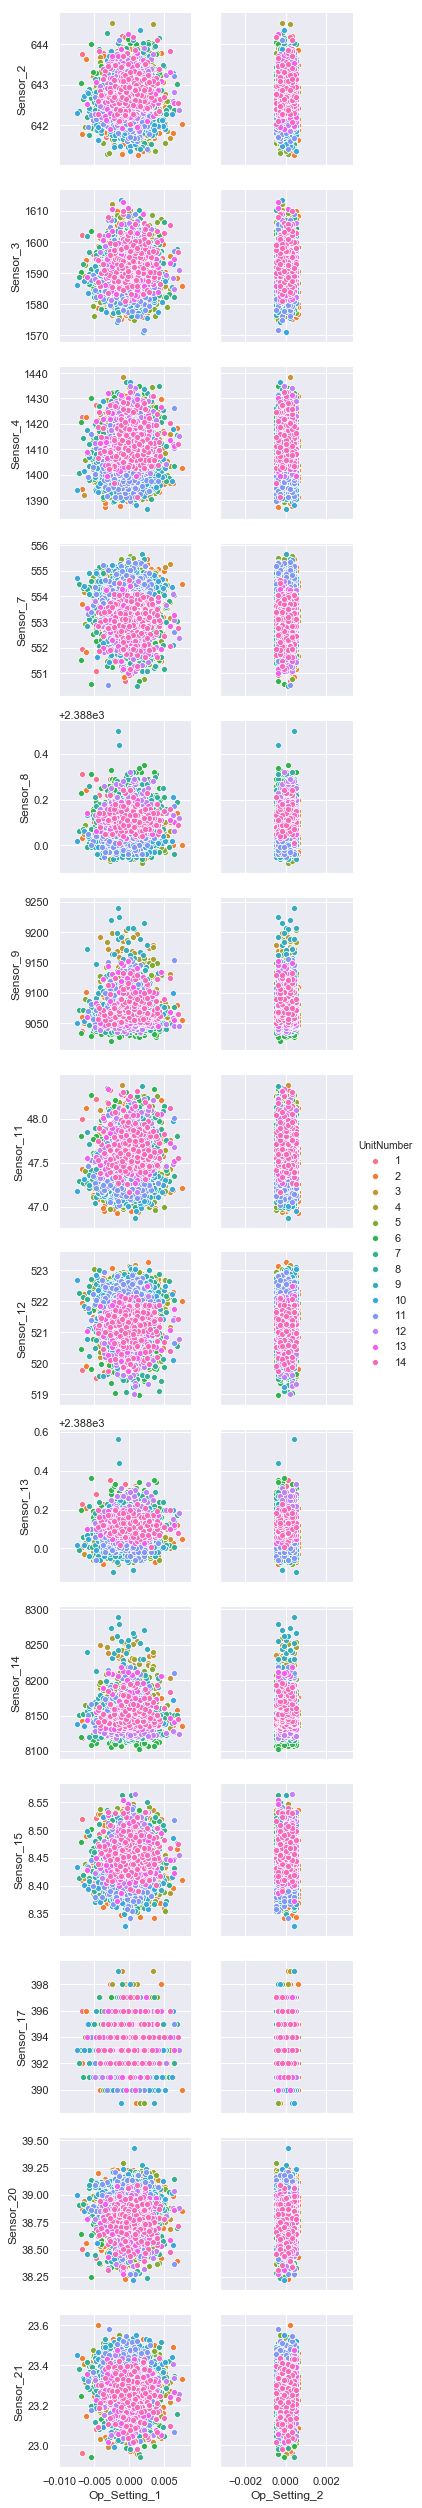

In [254]:
# operational setting 3 is stable, let's visualize op setting 1 and 2 against some of the most active sensors

g = sns.pairplot(data=train_with_target.query('UnitNumber < 15'),
                 x_vars=["Op_Setting_1","Op_Setting_2"],
                 y_vars=["Sensor_2", "Sensor_3", "Sensor_4", "Sensor_7", "Sensor_8", "Sensor_9", "Sensor_11", "Sensor_12", "Sensor_13", "Sensor_14", "Sensor_15", "Sensor_17", "Sensor_20", "Sensor_21"],
                 hue="UnitNumber", aspect=1)

In [308]:

#clear out target variable leakage to avoid unrealistic predictions

print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)

# set up features and target variable 

y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

(20631, 27)
(20631, 22)


In [309]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)
print("complete")

complete


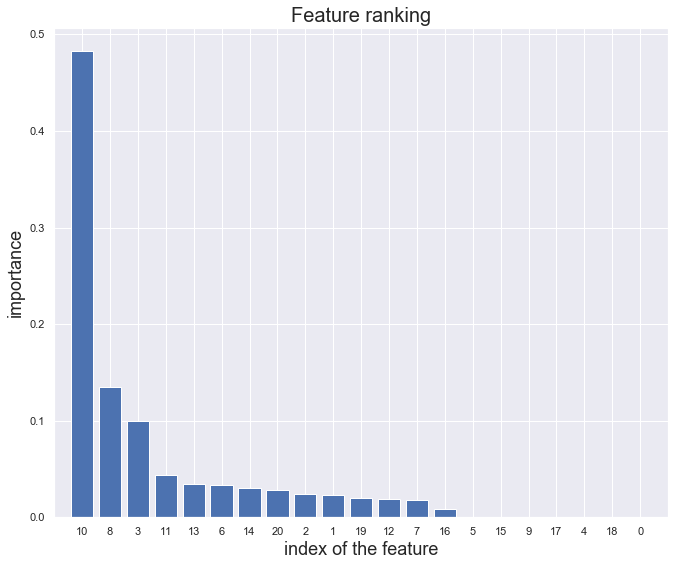

Sensor_11    0.482401
Sensor_9     0.134431
Sensor_4     0.100001
Sensor_12    0.044266
Sensor_14    0.034165
Sensor_7     0.033934
Sensor_15    0.029944
Sensor_21    0.027860
Sensor_3     0.024435
Sensor_2     0.023333
dtype: float64


In [310]:
# graph feature importance
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

In [311]:
#based on feature_importance we will remove not important data
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 22)
(20631, 16)


In [312]:
#train.columns
from sklearn import preprocessing

from sklearn import preprocessing

categorical = train_final.select_dtypes(include=['object'])

numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
#print(numeric.columns.values)

[]


In [313]:


from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)

y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)

[]
Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [260]:
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
C:\Users\17146\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
Random Forest Mean Squared Error:  1779.1965500366184
Random Forest Mean Absolute Error:  29.97049226930982
Random Forest r-squared:  0.6235444367275385


In [261]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.linear_model import ElasticNet
glm_net = ElasticNet()

# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', glm_net) ])
# tune the model
my_alpha = np.linspace(.01, 1, num=5)
my_l1_ratio = np.linspace(.01, 1, num=3)
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_glm_net = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__l1_ratio = my_l1_ratio, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_glm_net.fit(X_train, y_train)
# show the best model estimators
print(optimized_glm_net.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_glm_net.predict(X_test)
print("GLM Elastic Net Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("GLM Elastic Net Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("GLM Elastic Net r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.9s


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])
GLM Elastic Net Mean Squared Error:  2043.0311342906373
GLM Elastic Net Mean Absolute Error:  34.600517455166916
GLM Elastic Net r-squared:  0.5677203643258366


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.1s finished


In [262]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import svm
from sklearn.svm import SVR
svm = svm.SVR()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', svm) ])
# tune the model
my_C = [1]
my_epsilon = [.05, .1, .15]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_svm = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__C = my_C, model__epsilon = my_epsilon)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_svm.fit(X_train, y_train)
# show the best model estimators
print(optimized_svm.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_svm.predict(X_test)
print("SVM Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("SVM Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("SVM r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.9min finished
C:\Users\17146\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.05,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])
SVM Mean Squared Error:  1858.154949223506
SVM Mean Absolute Error:  30.319590062171176
SVM r-squared:  0.6068378347276752


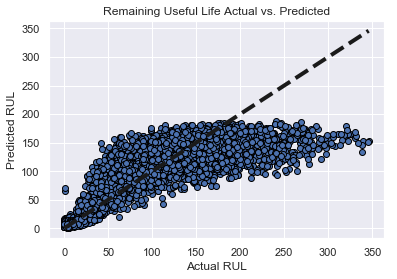

In [263]:
# plot actual vs predicted Remaining Useful Life for the best model (GBM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [264]:
# now let's look at turning this into a classification sol -> can we confidently identify when an asset within its last 15 cycles?
# generate label columns for training data
cycles = 15
train_no_leakage['Target_15_Cycles'] = np.where(train_no_leakage['Target_Remaining_Useful_Life'] <= cycles, 1, 0 )
train_no_leakage.tail(5)

,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life,Target_15_Cycles
20626,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1
20630,518.67,643.85,1600.38,1432.14,14.62,21.61,550.79,2388.26,9061.48,1.3,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0,1


In [265]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
target_to_drop = ['Target_Remaining_Useful_Life']
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
train_final = train_no_leakage.drop(target_to_drop, axis = 1)
train_final.tail()

(20631, 23)


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_15_Cycles
20626,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,1
20627,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,1
20628,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,1
20629,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
20630,518.67,643.85,1600.38,1432.14,14.62,21.61,550.79,2388.26,9061.48,1.3,...,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,1


In [266]:
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_15_Cycles']
X = numeric.drop(['Target_15_Cycles'], axis = 1)

[]
Sensor_1
Sensor_2
Sensor_3
Sensor_4
Sensor_5
Sensor_6
Sensor_7
Sensor_8
Sensor_9
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_15
Sensor_16
Sensor_17
Sensor_18
Sensor_19
Sensor_20
Sensor_21
Target_15_Cycles


In [267]:

# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1]
y_pred = optimized_rf.predict(X_test)
print(optimized_rf.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.6s finished
C:\Users\17146\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\17146\Anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\17146\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
 ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


C:\Users\17146\Anaconda\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\17146\Anaconda\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Confusion Matrix:
[[3785   57]
 [  36  249]]
Random Forest Accuracy: 97.7%
Random Forest Precision: 81.4%
Random Forest Recall: 87.4%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3842
           1       0.81      0.87      0.84       285

   micro avg       0.98      0.98      0.98      4127
   macro avg       0.90      0.93      0.92      4127
weighted avg       0.98      0.98      0.98      4127



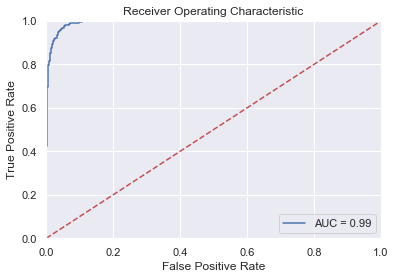

In [268]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print("Random Forest Accuracy: "+"{:.1%}".format(accuracy_score(y_test, y_pred)));
print("Random Forest Precision: "+"{:.1%}".format(precision_score(y_test, y_pred)));
print("Random Forest Recall: "+"{:.1%}".format(recall_score(y_test, y_pred)));
print("Classification Report:")
print(classification_report(y_test, y_pred))
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [271]:
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()